<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250503%5D%20FedAvg-DL%20vs%20TrustFed_MLP-LSTM%20on%20WSN-BFSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg-DL vs TrustFed // with MLP-LSTM model 4 classes on WSN-BFSF**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset.csv") #WSN-BFSF 4 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,Event,Time,S_Node,Node_id,Rest_Energy,Trace_Level,Mac_Type_Pckt,Source_IP_Port,Des_IP_Port,Packet_Size,TTL,Hop_Count,Broadcast_ID,Dest_Node_Num,Dest_Seq_Num,Src_Node_ID,Src_Seq_Num,Class
0,1,0.100000,79,79,600.000000,5,0,79.255,1.255,48,30,1,1,100,0,79,4,0
1,2,0.100963,78,78,599.979723,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
2,2,0.100963,76,76,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
3,2,0.100964,75,75,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
4,2,0.100964,118,118,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312101,4,656.526536,140,140,465.332078,5,800,140.255,1.255,48,30,1,31,100,16,140,68,1
312102,4,657.209643,140,140,465.191806,5,800,140.255,1.255,48,30,1,33,100,16,140,72,1
312103,4,657.891729,140,140,465.051737,5,800,140.255,1.255,48,30,1,35,100,16,140,76,1
312104,4,658.574656,140,140,464.911501,5,800,140.255,1.255,48,30,1,37,100,16,140,80,1


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [262851  11766   7645  29844]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [262851 262851 262851 262851]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**The hybrid MLP + LSTM model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed, InputLayer
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the input data for LSTM compatibility
# Assuming the input features need to be reshaped into a 3D array: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the hybrid MLP + LSTM model with regularization
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=input_shape))

    # LSTM Layer
    model.add(LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # MLP Layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])  # Adjusted for LSTM input format
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 295s 11ms/step - accuracy: 0.7804 - loss: 0.6231 - val_accuracy: 0.9076 - val_loss: 0.2802
Epoch 2/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 289s 11ms/step - accuracy: 0.9080 - loss: 0.2920 - val_accuracy: 0.9341 - val_loss: 0.2162
Epoch 3/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 286s 11ms/step - accuracy: 0.9280 - loss: 0.2393 - val_accuracy: 0.9535 - val_loss: 0.1660
Epoch 4/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 284s 11ms/step - accuracy: 0.9397 - loss: 0.2084 - val_accuracy: 0.9565 - val_loss: 0.1578
Epoch 5/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 282s 11ms/step - accuracy: 0.9469 - loss: 0.1892 - val_accuracy: 0.9444 - val_loss: 0.1810
Epoch 6/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 283s 11ms/step - accuracy: 0.9520 - loss: 0.1754 - val_accuracy: 0.9653 - val_loss: 0.1309
Epoch 7/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 281s 11ms/step - accuracy: 0.9541 - loss: 0.1727 - val_accuracy: 0.9646 - val_loss: 0.1268
Epoch 8/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 286s 11ms/s

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9871980826
Precision: 0.9872166917
Recall: 0.9871980826
F1-Score: 0.9872008521


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[51924   313   332     1]
 [  961 51544    16    49]
 [  104    49 52134   283]
 [    0   436   148 51987]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.98771162 0.98048317 0.9917063  0.98889121]


**Federated Learning Simulation (FedAvg)**

In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to measure model performance
def evaluate_global_model(global_model, X_test, y_test):
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute performance metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.10f}")
    print(f"Precision: {precision:.10f}")
    print(f"Recall: {recall:.10f}")
    print(f"F1-Score: {f1:.10f}")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1

# Function to analyze communication overhead
def analyze_communication_overhead(local_weights, global_weights):
    communication_cost = 0
    for i in range(len(local_weights)):
        # Compute the size of weights transmitted between clients and server
        communication_cost += sum(w.nbytes for w in local_weights[i])
    communication_cost += sum(w.nbytes for w in global_weights)

    print(f"\nCommunication Overhead: {communication_cost / (1024 ** 2):.4f} MB")  # in megabytes

# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    global_weights = global_model.get_weights()

    communication_overhead = []
    latency_per_round = []

    for round in range(30):  # Simulate 30 communication rounds
        local_weights = []

        start_time = time.time()  # Start measuring latency

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Measure latency
        end_time = time.time()
        latency = end_time - start_time
        latency_per_round.append(latency)

        # Measure communication overhead
        analyze_communication_overhead(local_weights, global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"\nRound {round + 1}: Global Model Accuracy = {acc:.10f}")

        # Evaluate model performance metrics
        evaluate_global_model(global_model, X_test, y_test)

    # Summarize overall latency
    print("\nLatency Analysis:")
    print(f"Average Latency per Round: {np.mean(latency_per_round):.8f} seconds")
    print(f"Total Latency for 10 Rounds: {np.sum(latency_per_round):.8f} seconds")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 1: Global Model Accuracy = 0.4714310765
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step

Model Performance Metrics:
Accuracy: 0.4714310851
Precision: 0.5190677540
Recall: 0.4714310851
F1-Score: 0.4736264708

Confusion Matrix:
[[12502 32020  7808   240]
 [ 8722 32338  7088  4422]
 [13798  8425 28552  1795]
 [  272 20396  6162 25741]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 2: Global Model Accuracy = 0.8604343534
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.8604343712
Precision: 0.8577715465
Recall: 0.8604343712
F1-Score: 0.8575727550

Confusion Matrix:
[[38142  9532  4896     0]
 [ 7424 41209   531  3406]
 [  293   472 50215  1590]
 [    0   231   973 51367]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 3: Global Model Accuracy = 0.8973754048
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.8973754167
Precision: 0.9021596499
Recall: 0.8973754167
F1-Score: 0.8951875027

Confusion Matrix:
[[38600 10012  3958     0]
 [ 1632 47800   109  3029]
 [  231    99 50568  1672]
 [    0   415   423 51733]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 4: Global Model Accuracy = 0.9035671353
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step

Model Performance Metrics:
Accuracy: 0.9035671316
Precision: 0.9111770658
Recall: 0.9035671316
F1-Score: 0.9014635478

Confusion Matrix:
[[38591 10165  3814     0]
 [  397 49172   104  2897]
 [  148   136 50843  1443]
 [    0   295   879 51397]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 5: Global Model Accuracy = 0.9237496257
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step

Model Performance Metrics:
Accuracy: 0.9237496493
Precision: 0.9293262553
Recall: 0.9237496493
F1-Score: 0.9226963868

Confusion Matrix:
[[41497  8155  2918     0]
 [  253 49963    43  2311]
 [   77   118 51686   689]
 [    0   789   681 51101]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 6: Global Model Accuracy = 0.9259181619
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step

Model Performance Metrics:
Accuracy: 0.9259181762
Precision: 0.9308806148
Recall: 0.9259181762
F1-Score: 0.9249389131

Confusion Matrix:
[[41968  7894  2708     0]
 [  255 49717    40  2558]
 [  116    98 52126   230]
 [    0   586  1093 50892]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 7: Global Model Accuracy = 0.9241300821
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step

Model Performance Metrics:
Accuracy: 0.9241300926
Precision: 0.9288272783
Recall: 0.9241300926
F1-Score: 0.9232880181

Confusion Matrix:
[[42315  7359  2896     0]
 [  218 49986    25  2341]
 [  137    98 51142  1193]
 [    0   628  1059 50884]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 8: Global Model Accuracy = 0.9346065521
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9346065503
Precision: 0.9377413421
Recall: 0.9346065503
F1-Score: 0.9338329387

Confusion Matrix:
[[43480  6327  2763     0]
 [  392 49803    31  2344]
 [  137    91 52022   320]
 [    0   318  1028 51225]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 9: Global Model Accuracy = 0.9307783246
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9307783395
Precision: 0.9348159045
Recall: 0.9307783395
F1-Score: 0.9299510112

Confusion Matrix:
[[42910  6986  2674     0]
 [  296 49877    53  2344]
 [   78    81 52187   224]
 [    0   315  1505 50751]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 10: Global Model Accuracy = 0.9353008866
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9353008593
Precision: 0.9392617310
Recall: 0.9353008593
F1-Score: 0.9346902870

Confusion Matrix:
[[43638  6307  2622     3]
 [  315 50433    47  1775]
 [   89    83 52387    11]
 [    0   780  1573 50218]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 11: Global Model Accuracy = 0.9393953681
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9393953805
Precision: 0.9440697080
Recall: 0.9393953805
F1-Score: 0.9391122495

Confusion Matrix:
[[44519  5774  2277     0]
 [  361 51428    41   740]
 [   86    80 52401     3]
 [    0  1754  1628 49189]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 12: Global Model Accuracy = 0.9371032119
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9371032095
Precision: 0.9408954420
Recall: 0.9371032095
F1-Score: 0.9365636813

Confusion Matrix:
[[43944  6232  2394     0]
 [  308 50526    43  1693]
 [   95    81 52389     5]
 [    0   742  1633 50196]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 13: Global Model Accuracy = 0.9317912459
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9317912698
Precision: 0.9393114503
Recall: 0.9317912698
F1-Score: 0.9313216763

Confusion Matrix:
[[42740  7148  2682     0]
 [  118 51943    41   468]
 [   62    99 52346    63]
 [    0  2236  1426 48909]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 14: Global Model Accuracy = 0.9525777698
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9525777412
Precision: 0.9548719183
Recall: 0.9525777412
F1-Score: 0.9524024106

Confusion Matrix:
[[46317  4342  1911     0]
 [  444 51235    30   861]
 [  109    75 52364    22]
 [    0  1281   897 50393]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 15: Global Model Accuracy = 0.9460816979
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step

Model Performance Metrics:
Accuracy: 0.9460816717
Precision: 0.9501126933
Recall: 0.9460816717
F1-Score: 0.9460227461

Confusion Matrix:
[[46046  4470  2054     0]
 [  452 51804    26   288]
 [  134    75 52357     4]
 [    0  2455  1380 48736]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 16: Global Model Accuracy = 0.9549555182
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9549555119
Precision: 0.9576101700
Recall: 0.9549555119
F1-Score: 0.9548266972

Confusion Matrix:
[[46389  4489  1692     0]
 [  423 51739    26   382]
 [  116    73 52371    10]
 [    0  1353   908 50310]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 17: Global Model Accuracy = 0.9506089687
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step

Model Performance Metrics:
Accuracy: 0.9506089471
Precision: 0.9541471057
Recall: 0.9506089471
F1-Score: 0.9505378009

Confusion Matrix:
[[46299  4429  1842     0]
 [  430 51932    33   175]
 [  107    75 52385     3]
 [    0  1979  1313 49279]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 18: Global Model Accuracy = 0.9205539227
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9205539255
Precision: 0.9221836419
Recall: 0.9205539255
F1-Score: 0.9205475396

Confusion Matrix:
[[45275  5210  2085     0]
 [ 4530 47407    38   595]
 [   67    69 52434     0]
 [    0  2887  1225 48459]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 19: Global Model Accuracy = 0.9508895278
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9508895240
Precision: 0.9545605509
Recall: 0.9508895240
F1-Score: 0.9508320037

Confusion Matrix:
[[46528  4150  1892     0]
 [  399 52071    34    66]
 [   92    75 52400     3]
 [    0  2127  1489 48955]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 20: Global Model Accuracy = 0.9616751075
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9616750919
Precision: 0.9633591090
Recall: 0.9616750919
F1-Score: 0.9614911257

Confusion Matrix:
[[46988  3806  1776     0]
 [  504 51746    27   293]
 [   96    51 52419     4]
 [    0   801   701 51069]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 21: Global Model Accuracy = 0.9591498971
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9591498994
Precision: 0.9604211211
Recall: 0.9591498994
F1-Score: 0.9589878888

Confusion Matrix:
[[47405  3475  1690     0]
 [  532 51112    24   902]
 [  112    54 52402     2]
 [    0   566  1233 50772]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 22: Global Model Accuracy = 0.9559066296
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9559066202
Precision: 0.9586035353
Recall: 0.9559066202
F1-Score: 0.9558096926

Confusion Matrix:
[[46969  3674  1927     0]
 [  484 51997    34    55]
 [   73    57 52437     3]
 [    0  1538  1427 49606]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 23: Global Model Accuracy = 0.9633823037
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9633823313
Precision: 0.9650173024
Recall: 0.9633823313
F1-Score: 0.9633634918

Confusion Matrix:
[[48274  2819  1477     0]
 [  635 51866    29    40]
 [   85    57 52426     2]
 [    0  1502  1054 50015]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 24: Global Model Accuracy = 0.9639387131
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9639387296
Precision: 0.9657214943
Recall: 0.9639387296
F1-Score: 0.9639071426

Confusion Matrix:
[[47928  3296  1346     0]
 [  494 52013    17    46]
 [   98    57 52412     3]
 [    0  1313   913 50345]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 25: Global Model Accuracy = 0.9659788609
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9659788569
Precision: 0.9674788210
Recall: 0.9659788569
F1-Score: 0.9660123500

Confusion Matrix:
[[48810  2683  1077     0]
 [  610 51899    21    40]
 [   99    52 52417     2]
 [    0  1689   881 50001]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 26: Global Model Accuracy = 0.9558590651
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9558590648
Precision: 0.9577622916
Recall: 0.9558590648
F1-Score: 0.9557611562

Confusion Matrix:
[[47364  3194  2012     0]
 [  499 51340    32   699]
 [   62    50 52449     9]
 [    0  1529  1196 49846]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 27: Global Model Accuracy = 0.9640195966
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9640195738
Precision: 0.9658528484
Recall: 0.9640195738
F1-Score: 0.9639827418

Confusion Matrix:
[[47961  3228  1381     0]
 [  424 52074    28    44]
 [   97    41 52432     0]
 [    0  1319  1004 50248]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 28: Global Model Accuracy = 0.9639292359
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step

Model Performance Metrics:
Accuracy: 0.9639292185
Precision: 0.9656607202
Recall: 0.9639292185
F1-Score: 0.9638803844

Confusion Matrix:
[[47937  3170  1463     0]
 [  516 51989    19    46]
 [   69    48 52450     3]
 [    0  1261   990 50320]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 29: Global Model Accuracy = 0.9677764773
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9677764515
Precision: 0.9692484097
Recall: 0.9677764515
F1-Score: 0.9677563115

Confusion Matrix:
[[48353  3066  1151     0]
 [  437 52070    18    45]
 [   76    56 52436     2]
 [    0  1142   783 50646]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.7721 MB

Round 30: Global Model Accuracy = 0.9687466025
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

Model Performance Metrics:
Accuracy: 0.9687465820
Precision: 0.9698099711
Recall: 0.9687465820
F1-Score: 0.9687200617

Confusion Matrix:
[[48759  2490  1321     0]
 [  633 51875    19    43]
 [  111    45 52412     2]
 [    0  1112   796 50663]]

Latency Analysis:
Average Latency per Round: 251.27385411 seconds
Total Latency for 10 Rounds: 7538.21562338 seconds


In [ ]:
!pip install tensorflow

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



===== Round 1 =====
Poisoned clients this round: [0]
Global Accuracy = 0.24999881 | Avg Trust: 0.55689006

===== Round 2 =====
Poisoned clients this round: [2]
Global Accuracy = 0.24999881 | Avg Trust: 0.53238096

===== Round 3 =====
Poisoned clients this round: [2]
Global Accuracy = 0.24999881 | Avg Trust: 0.53105130

===== Round 4 =====
Poisoned clients this round: [1]
Global Accuracy = 0.25000358 | Avg Trust: 0.53366209

===== Round 5 =====
Poisoned clients this round: [2]
Global Accuracy = 0.24999881 | Avg Trust: 0.54349277

===== Round 6 =====
Poisoned clients this round: [4]
Global Accuracy = 0.25000358 | Avg Trust: 0.52554533

===== Round 7 =====
Poisoned clients this round: [4]
Global Accuracy = 0.25000358 | Avg Trust: 0.52338730

===== Round 8 =====
Poisoned clients this round: [1]
Global Accuracy = 0.25000358 | Avg Trust: 0.53513252

===== Round 9 =====
Poisoned clients this round: [0]
Global Accuracy = 0.25000358 | Avg Trust: 0.53293833

===== Round 10 =====
Poisoned client

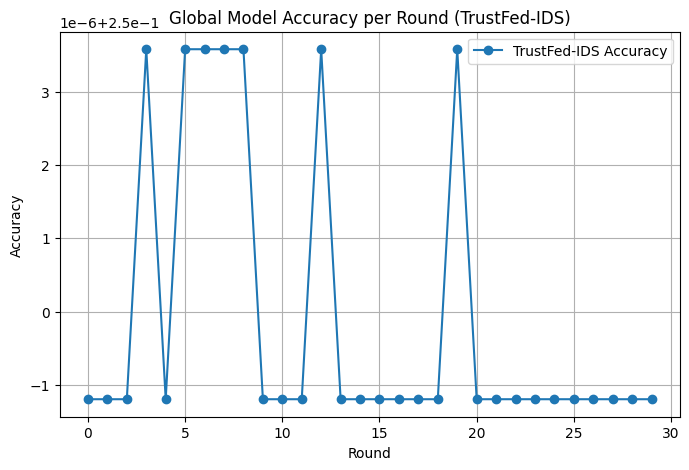

In [ ]:
acc_history, trust_history, latency_history = trustfed_ids_simulation( # Include latency_history in assignment
    X_train, y_train, X_test, y_test,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=y_train.shape[1],
    num_clients=5,
    rounds=30,
    poison_ratio=0.2,
    trust_threshold=0.6
)

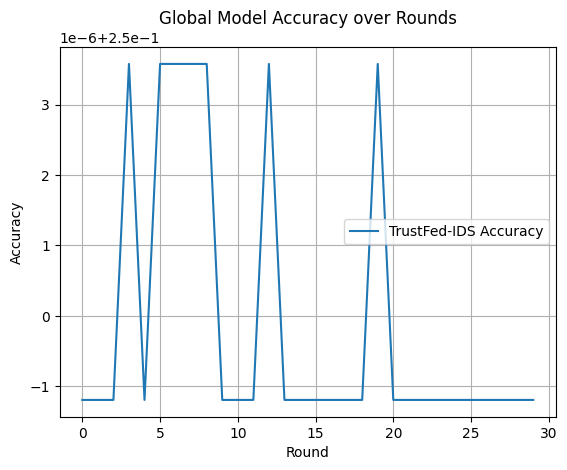

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc_history, label='TrustFed-IDS Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Global Model Accuracy over Rounds')
plt.grid(True)
plt.legend()
plt.show()